In [393]:
# Choose which figure to plot (image / record)
cnn_based_mode = 'image' 
# Need zoom windows? (True / False)
enable_zoom_windows = True
# Need ruler guides? (True / False)
# Default: Average prediction time of CNN models
enable_ruler_guides = True

## Import Libraries

In [394]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from matplotlib.cm import tab20
from math import ceil
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

## Read Data

In [395]:
source = pd.read_excel('acc-time.xlsx')
source.dropna(axis=0, inplace=True)
# source

In [396]:
datasets = source['Datasets'].value_counts().index.to_list()
print(datasets)
model_methods = source['Model'].value_counts().index.to_list()
print(model_methods)

['CICIDS2017', 'IoTID20', 'UNSW-NB15', 'NSL-KDD', 'KDD-Cup99']
['XG', 'RF', 'DT', 'ET', 'Stacking', 'CNN', 'Xception', 'VGG16', 'VGG19', 'ResNet', 'Inception', 'InceptionResnet']


In [397]:
dfs = {dataset: source[source['Datasets']==dataset] for dataset in datasets}
dfs.keys()

dict_keys(['CICIDS2017', 'IoTID20', 'UNSW-NB15', 'NSL-KDD', 'KDD-Cup99'])

## Plot

### Set plotting config

In [398]:
datasets_order = datasets
model_order = model_methods
model_color_dict = {model_order[i]: tab20(i) for i in range(len(model_order))}
model_marker_dict = {
    'default': '.',
    'XG': '$X$',
    'RF': '$R$',
    'DT': '$D$',
    'ET': '$E$',
    'Stacking': '$S$',
    'CNN': 'D',
    'Xception': '^',
    'VGG16': 's',
    'VGG19': 'P',
    'ResNet': '*',
    'Inception': 'X',
    'InceptionResnet': 'o'
}

In [399]:
col_num = len(datasets)
row_num = (len(datasets_order)-1)//col_num+1

In [400]:
def create_scatter_plot(ax, df_dataset, s=50, alpha=0.7, lw=2, model_color_dict=model_color_dict, model_marker_dict=model_marker_dict, model_order=model_order):
    time_col = 'Predict_time_per_record' if cnn_based_mode == 'record' else 'Predict_time'
    dataset_model = df_dataset['Model'].value_counts().index.to_list()
    points = {}
    for model in model_order:
        if model not in dataset_model: continue
        df_model = df_dataset[df_dataset['Model']==model]
        x = df_model[time_col].values * 1000    # s --> ms
        y = df_model['Accuracy'].values
        points[model] = (x, y)
        ax.scatter(x, y, s=s, label=model, color=model_color_dict[model], marker=model_marker_dict[model], alpha=alpha, lw=lw)
    return points

In [401]:
mth_ids_methods = ['XG', 'RF', 'DT', 'ET', 'Stacking']
cnn_based_models = ['CNN', 'Xception', 'VGG16', 'VGG19', 'Inception', 'ResNet', 'InceptionResnet']

In [402]:
def create_zoom_plot(ax, dataset, include=mth_ids_methods, x0=0.13, y0=0.08, width=0.35, height=0.3, x_ratio=0.2, y_ratio=0.2, x_margin=None, y_margin=None, loc1=3, loc2=1, s=50, alpha=0.7, lw=2, model_color_dict=model_color_dict, model_marker_dict=model_marker_dict, model_order=model_order):
    # Create inner axes
    axins = ax.inset_axes((x0, y0, width, height))
    df_dataset = dfs[dataset]
    # Draw scatter plot in inner axes
    points = create_scatter_plot(axins, df_dataset)
    points = [points[temp] for temp in include]
    x = [x for x, y in points]
    y = [y for x, y in points]
    zone_left = min(x)
    zone_right = max(x)
    zone_bottom = min(y)
    zone_top = max(y)
    if x_margin is None: 
        x_lim0 = zone_left-(zone_right-zone_left)*x_ratio
        x_lim1 = zone_right+(zone_right-zone_left)*x_ratio 
    else: 
        x_lim0 = zone_left-x_margin
        x_lim1 = zone_right+x_margin
    if y_margin is None: 
        y_lim0 = zone_bottom-(zone_top-zone_bottom)*y_ratio
        y_lim1 = zone_top+(zone_top-zone_bottom)*y_ratio
    else:
        y_lim0 = zone_bottom-y_margin
        y_lim1 = zone_top+y_margin
    axins.set_xlim(x_lim0, x_lim1)
    axins.set_ylim(y_lim0, y_lim1)
    axins.grid(which='major', axis='both', lw=1)
    axins.grid(which='minor', axis='both', lw=0.4)
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec='k', lw=1)

In [403]:
def get_average_value(points:list[str], df_dataset:pd.DataFrame, axis:str='both'):
    dataset_model = df_dataset['Model'].value_counts().index.to_list()
    for point in points: 
        if point not in dataset_model: raise Exception('Cannot find point {}'.format(point))
    time_col = 'Predict_time_per_record' if cnn_based_mode == 'record' else 'Predict_time'
    df_dataset = df_dataset[df_dataset['Model'].isin(points)]
    x_avg = df_dataset[time_col].values.mean()
    y_avg = df_dataset['Accuracy'].values.mean()
    if axis == 'x': return x_avg
    elif axis == 'y': return y_avg
    elif axis == 'both': return (x_avg, y_avg)
    else: raise Exception('Wrong axis')

In [404]:
def plot_ruler_guides(ax: plt.Axes, dataset:str, target, axis:str='x', color:str='r', linestyle:str='--', **kwargs):
    # Get the values
    if type(target) == type([]): 
        x, y = get_average_value(target, dfs[dataset], axis='both')
        x *= 1000
        y *= 1000
    else: 
        x=target
        y=target
    # Plot ruler guides
    if axis =='x' or axis == 'both': ax.axvline(x=x, color=color , linestyle=linestyle, **kwargs)
    if axis =='y' or axis == 'both': ax.axhline(y=y, color=color , linestyle=linestyle, **kwargs)

### Set zoom windows drawing rules

In [405]:
# Configure the zoom windows to draw in image mode
image_zoom_config = [(dataset, {}) for dataset in datasets_order]
# Configure the zoom windows to draw in record mode
record_zoom_config = [
        (
            'CICIDS2017',
            {
                'include': ['DT', 'XG'],
                'x0': 0.6,
            }
        ),
        (
            'IoTID20',
            {
                'include': ['DT', 'XG'],
                'x0':0.6,
            }
        ),
        (
            'IoTID20',
            {
                'include': ['VGG16', 'VGG19'],
                'x0':0.65,
                'y0':0.65,
                'width': 0.25,
                'height': 0.2,
                'y_margin': 0.001,
            }
        ),
        (
            'UNSW-NB15',
            {
                'include': ['DT', 'XG'],
            }
        ),
        (
            'NSL-KDD',
            {
                'include': ['DT', 'XG', 'ET', 'RF', 'Stacking'],
            }
        ),
        (
            'KDD-Cup99',
            {
                'include': ['DT', 'XG', 'ET', 'RF', 'Stacking', 'Xception', 'VGG16', 'VGG19'],
                'x0':0.6,
            }
        ),
    ]

### Set ruler guides drawing rules

In [406]:
# Configure the guides to draw in image mode
image_guides_config = [(dataset, 'x', cnn_based_models, {}) for dataset in datasets_order]
# Configure the guides to draw in record mode
record_guides_config = [(dataset, 'x', cnn_based_models, {}) for dataset in datasets_order]

### Drawing

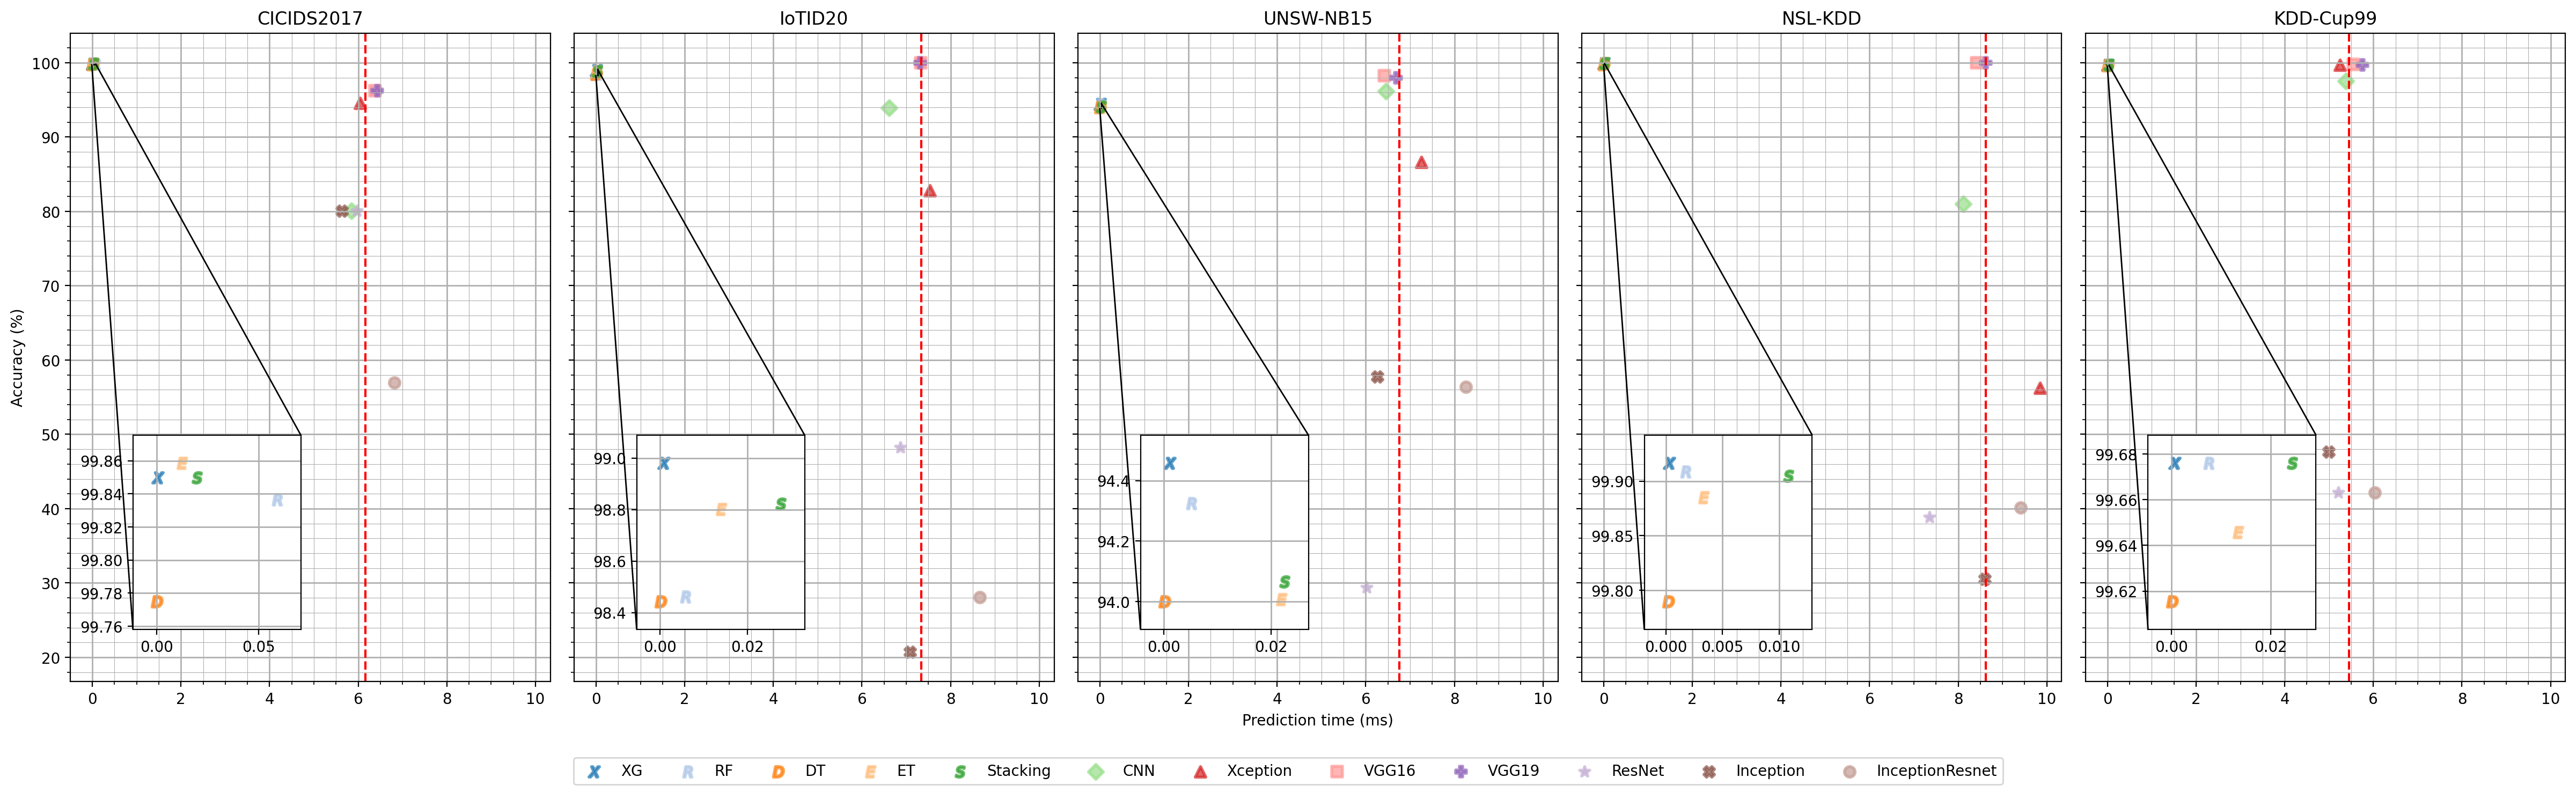

In [407]:
figure, axs = plt.subplots(row_num, col_num, figsize=(col_num*6,row_num*8), dpi=200, sharex=True, sharey=True)
figure.subplots_adjust(wspace=0.05)

def get_ax(i):
    if row_num == 1 or row_num == len(datasets_order): return axs[i]
    else: return axs[i//col_num, i%col_num]

# Plot subplots
for i in range(len(datasets_order)):
    if datasets_order[i] not in datasets: continue
    df_dataset = dfs[datasets_order[i]]
    # Set subplot label
    ax = get_ax(i)
    ax.set_title(datasets_order[i])
    # Scatter Plot
    create_scatter_plot(ax, df_dataset)
    # Additional config
    ax.minorticks_on()
    ax.grid(which='major', axis='both', lw=1)
    ax.grid(which='minor', axis='both', lw=0.4)
    # Add axis labels
    if i%col_num==0 and i//row_num+1 == ceil(row_num/2): ax.set_ylabel('Accuracy (%)')
    if i+col_num>=len(datasets_order) and i%col_num+1 == ceil(col_num/2): ax.set_xlabel('Prediction time (ms)')
    # Zoom
    # if cnn_based_mode != 'record' and enable_zoom_windows: create_zoom_plot(ax, datasets_order[i])

# Plot zoom windows
if enable_zoom_windows:
    zoom_config = record_zoom_config if cnn_based_mode == 'record' else image_zoom_config
    for ds_name, config_dict in zoom_config:
        if ds_name not in datasets or ds_name not in datasets_order: continue
        ax = get_ax(datasets_order.index(ds_name))
        create_zoom_plot(ax, ds_name, **config_dict)

# Plot ruler guides
if enable_ruler_guides:
    guides_config = record_guides_config if cnn_based_mode == 'record' else image_guides_config
    for ds_name, axis, target, config_dict in guides_config:
        if ds_name not in datasets or ds_name not in datasets_order: continue
        # Get the ax to draw
        ax = get_ax(datasets_order.index(ds_name))
        plot_ruler_guides(ax, ds_name, target, axis, **config_dict)
        
# Legend
figure.legend(model_order, loc='lower center', ncol=len(model_order))
# figure.tight_layout()
figure.savefig('acc-time.pdf', bbox_inches='tight', pad_inches=0.1)
# figure.show()